In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py

from akita_utils.utils import ut_dense

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_map_matrix(hf, num_sequences, head_index, model_index, num_background):
    """averaged over targets"""
    
    num_targets = 6
    if head_index != 1:
        num_targets = 5
    
    map_size = np.array(hf[f"e0_h{head_index}_m{model_index}_t0_b0"]).shape[0]
    
    map_matrix = np.zeros((map_size, map_size, num_sequences, num_background))

    for seq_index in range(num_sequences):
        for target_index in range(num_targets):
            for background_index in range(num_background):
                map_matrix[:, :, seq_index, background_index] += np.array(hf[f"e{seq_index}_h{head_index}_m{model_index}_t{target_index}_b{background_index}"])
    
    map_matrix = map_matrix / num_targets
    return map_matrix

def plot_map(matrix, vmin=-0.6, vmax=0.6, width=5, height=5, palette="RdBu_r"):

    """
    Plots a 512x512 map representating changes in the DNA contacts.

    Parameters
    ------------
    matrix : numpy array
        Changes in DNA contacts.
    vmin : float
    vmax : float
        Minimum and maximum in the colormap scale.
    width : int
    height : int
        Width and height of a plotted map.
    """

    fig = plt.figure(figsize=(width, height))

    sns.heatmap(
        matrix,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.show()
    

In [3]:
input_tsv_bg = "./../ctcf_tsv/all_motifs_boundary.tsv"
scores_tsv = "./../ctcf_tsv/filtered_base_mouse_ctcf_scores.tsv"

In [4]:
df = pd.read_table(input_tsv_bg, sep="\t")
df = df.drop(columns=["orientation", "flank_bp", "spacer_bp"])

In [5]:
scores_df = pd.read_table(scores_tsv, sep="\t")

In [6]:
def find_lower_boundary(request_exp_id, chunks_bounds):
    # finds the index of the biggest bound smaller than request_exp_id
    biggest_chunks_bound_index = 0
    for chunks_bound_index in range(len(chunks_bounds)):
        chunks_bound = chunks_bounds[chunks_bound_index]
        if chunks_bound < request_exp_id:
            biggest_chunks_bound_index = chunks_bound_index
        if chunks_bound > request_exp_id:
            return biggest_chunks_bound_index

def which_job(request_seq_id, request_bg_id, split_df, nr_sites, num_chunks):
    request_exp_id = request_bg_id * nr_sites + request_seq_id
    assert split_df.iloc[request_exp_id]["seq_id"] == request_seq_id

    # finding df boundaries
    df_len = len(df)
    chunks_bounds = np.linspace(0, df_len, num_chunks + 1, dtype="int")
    
    return find_lower_boundary(request_exp_id, chunks_bounds)

In [16]:
num_chunks = 20
nr_sites = len(scores_df)
model_index = 1

In [8]:
# requested seq_id
sample = [931, 5680, 1111, 7470, 510, 5750, 2000, 11, 5886]
sample.sort()

In [9]:
# background and target ids
request_bg_id = 0
request_tg_ids = [1, 4]

In [10]:
sample_exp_id = [nr_sites * request_bg_id + seq_id for seq_id in sample]

In [11]:
# figuring out in which jobs are requested samples
job_list = []

for seq_id in sample:
    index = which_job(seq_id, request_bg_id, df, nr_sites, num_chunks)
    if index not in job_list:
        job_list.append(index)

# Scores

In [13]:
scores_df.iloc[sample]

boundary_index  chrom  boundary_end  index  num_ctcf  \
11                 4   chr1       6200000     27         5   
510              341   chr1     184800000   1833         6   
931              620   chr2     132270000   3357         7   
1111             699   chr2     172220000   3912         5   
2000            1261   chr4     153490000   7132         7   
5680            3351  chr13      64450000  19861         5   
5750            3402  chr13      95360000  20115         2   
5886            3487  chr14      29120000  20603         6   
7470            4455  chr19      50190000  26275         4   

                     span  boundary_start strand      start        end  ...  \
11        6190724-6190743         6190000      -    6190724    6190743  ...   
510   184791293-184791312       184790000      -  184791293  184791312  ...   
931   132262949-132262968       132260000      +  132262949  132262968  ...   
1111  172216028-172216047       172210000      -  172216028  172216047  ...   
2000  153484596-153484615       153480000      -  153484596  153484615  ...   
5680    64443457-64443476        64440000      +   64443457   64443476  ...   
5750    95359224-95359243        95350000      -   95359224   95359243  ...   
5886    29110853-29110872        29110000      -   29110853   29110872  ...   
7470    50185467-50185486        50180000      +   50185467   50185486  ...   

      cross_m2_avg  dot_m2_avg  dotSCD_m2_avg  x_m2_avg  boSCD_avg  cross_avg  \
11       -0.000535    0.059651      11.495586 -0.001172  15.519752   0.000123   
510       0.349680    5.407341      39.496008  0.459071  39.586022   0.304038   
931       0.016324    0.291826      16.728470  0.021683  20.472182   0.016158   
1111      1.167727   22.706510      85.781257  1.669577  74.214174   1.240895   
2000      0.123699    1.835325      26.407563  0.159215  29.395342   0.140968   
5680      0.333032    5.496426      43.495777  0.448201  44.897801   0.420532   
5750      0.000518    0.124216       7.062441  0.000629   8.615625   0.000377   
5886      0.895525   15.949707      67.764106  1.238365  61.264183   0.936512   
7470      0.748682   12.724512      59.232222  1.016612  54.570336   0.702542   

        dot_avg  dotSCD_avg     x_avg  seq_id  
11     0.084054   14.391224 -0.000144      11  
510    4.776875   39.560396  0.400904     510  
931    0.308547   18.532702  0.021355     931  
1111  24.000065   87.543651  1.783723    1111  
2000   2.170308   30.492702  0.183564    2000  
5680   7.071147   50.354999  0.569708    5680  
5750   0.142951    8.618147  0.000286    5750  
5886  16.977018   72.751466  1.313199    5886  
7470  11.998226   60.918164  0.959870    7470  

[9 rows x 26 columns]

# Boundary maps

exp_id: 1111, seq_id: 1111, target_id: 1, background_id: 0


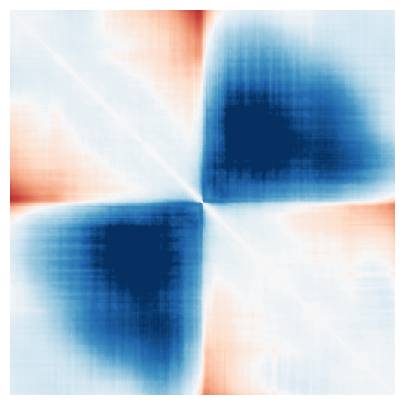

exp_id: 1111, seq_id: 1111, target_id: 4, background_id: 0


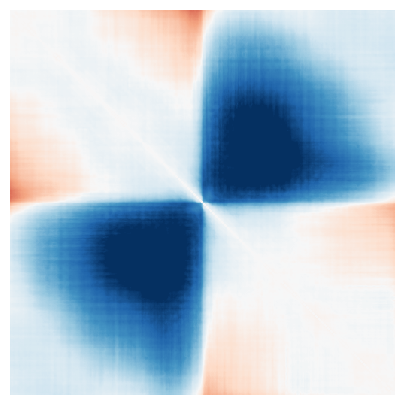

exp_id: 11, seq_id: 11, target_id: 1, background_id: 0


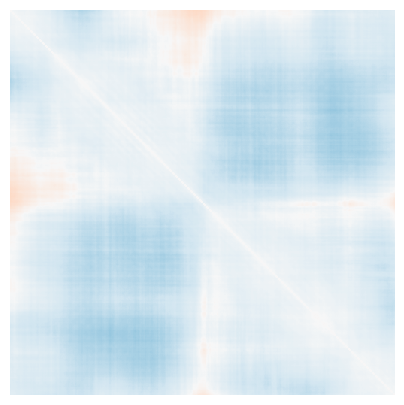

exp_id: 11, seq_id: 11, target_id: 4, background_id: 0


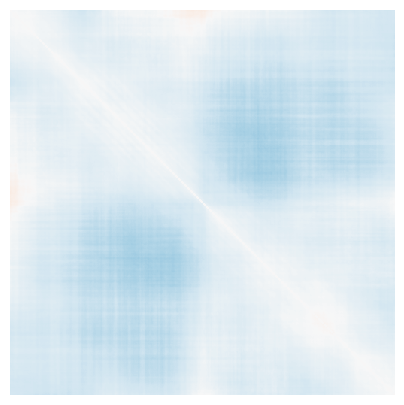

exp_id: 2000, seq_id: 2000, target_id: 1, background_id: 0


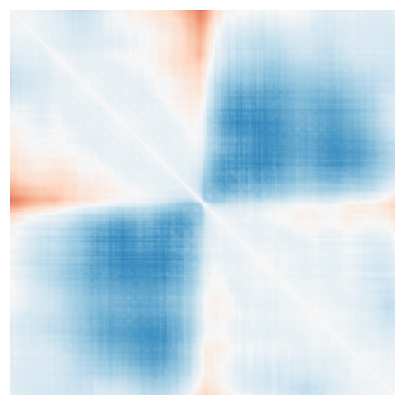

exp_id: 2000, seq_id: 2000, target_id: 4, background_id: 0


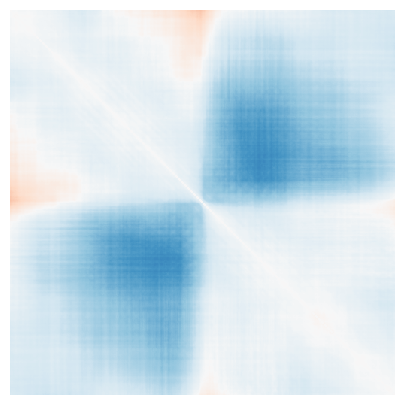

exp_id: 510, seq_id: 510, target_id: 1, background_id: 0


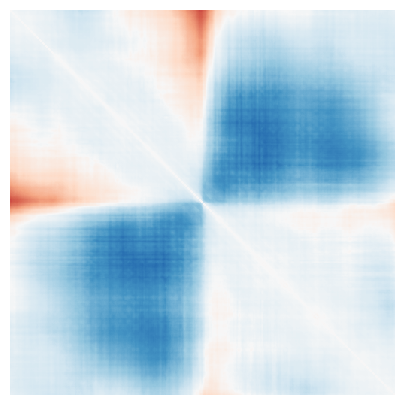

exp_id: 510, seq_id: 510, target_id: 4, background_id: 0


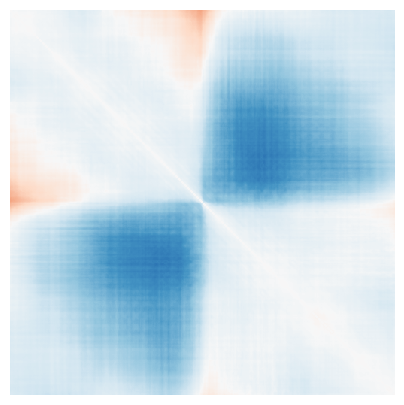

exp_id: 931, seq_id: 931, target_id: 1, background_id: 0


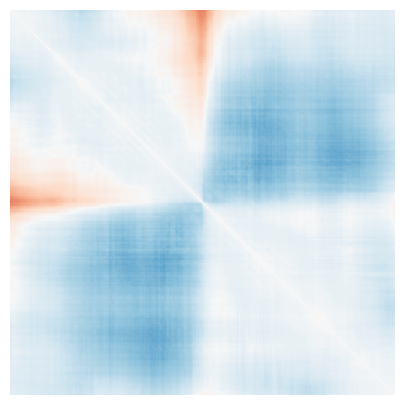

exp_id: 931, seq_id: 931, target_id: 4, background_id: 0


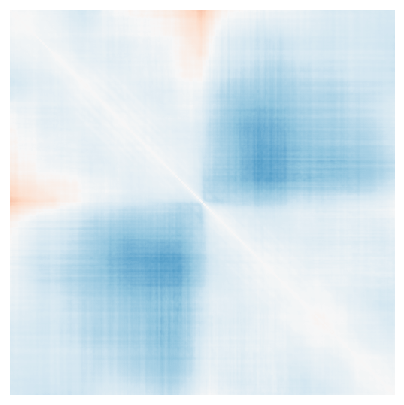

exp_id: 5680, seq_id: 5680, target_id: 1, background_id: 0


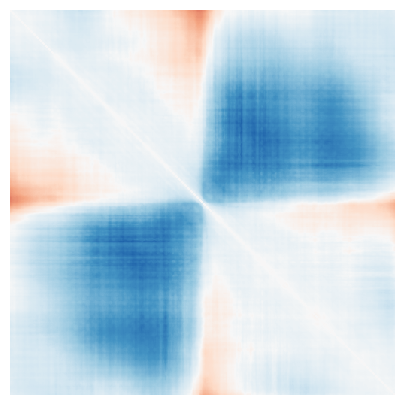

exp_id: 5680, seq_id: 5680, target_id: 4, background_id: 0


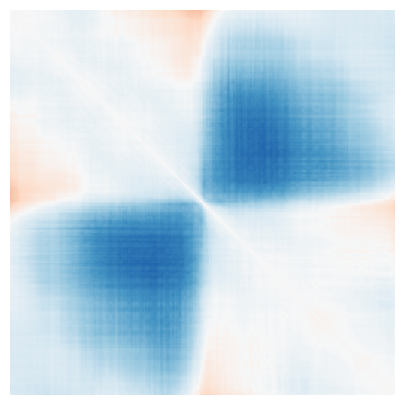

exp_id: 5750, seq_id: 5750, target_id: 1, background_id: 0


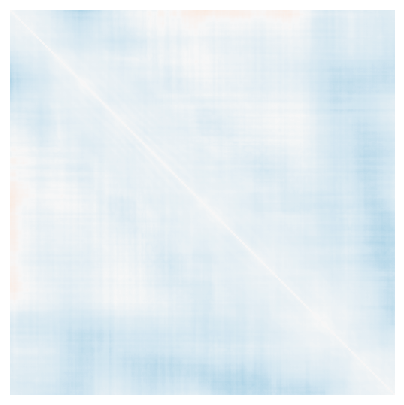

exp_id: 5750, seq_id: 5750, target_id: 4, background_id: 0


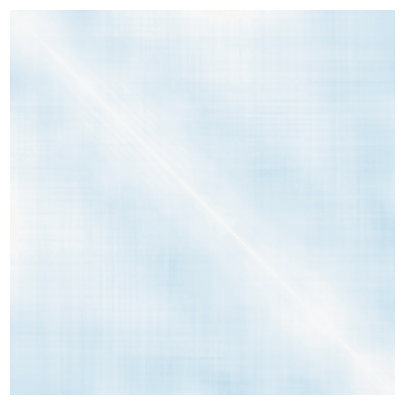

exp_id: 5886, seq_id: 5886, target_id: 1, background_id: 0


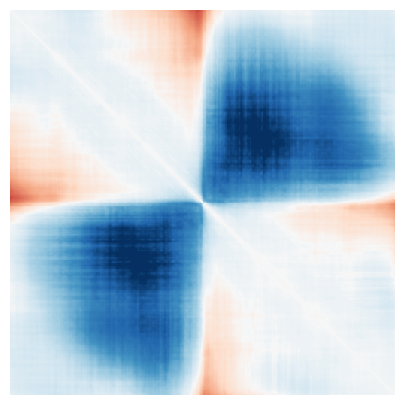

exp_id: 5886, seq_id: 5886, target_id: 4, background_id: 0


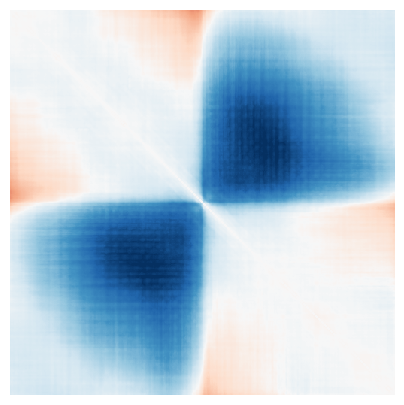

exp_id: 7470, seq_id: 7470, target_id: 1, background_id: 0


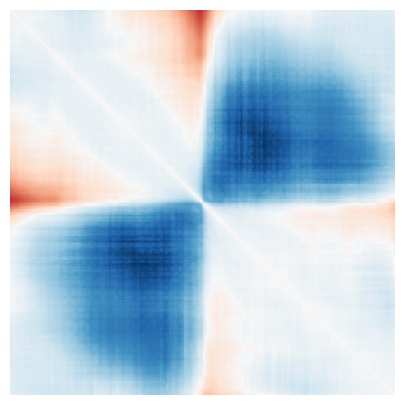

exp_id: 7470, seq_id: 7470, target_id: 4, background_id: 0


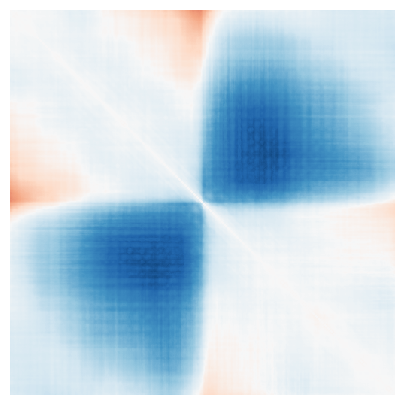

In [17]:
for job_index in job_list:

    job_h5_file = f"/scratch2/smaruj/corrected_dots_vs_boundaries/boundaries_all_motifs_m{model_index}/job{job_index}/OUT.h5"
    job_h5_open = h5py.File(job_h5_file, "r")
    
    # append to final
    for key in job_h5_open.keys():
            
        if (key[0] == "e" and key != "end" and key !="exp_id"):
                
            identifiers = key.split("_")
            exp_id = int(identifiers[0][1:])
            seq_id = int(identifiers[1][1:])
            target_id = int(identifiers[4][1:])
            background_id = int(identifiers[5][1:])

            if exp_id in sample_exp_id and seq_id in sample and background_id == request_bg_id and target_id in request_tg_ids:

                print(f"exp_id: {exp_id}, seq_id: {seq_id}, target_id: {target_id}, background_id: {background_id}")
            
                map_matrix = np.array(job_h5_open[key])

                plot_map(map_matrix)
    
    job_h5_open.close()
    

# Dot maps

exp_id: 1111, seq_id: 1111, target_id: 1, background_id: 0


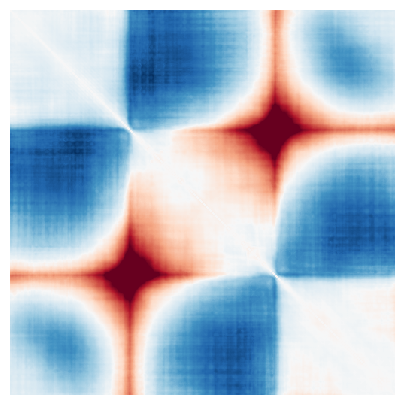

exp_id: 1111, seq_id: 1111, target_id: 4, background_id: 0


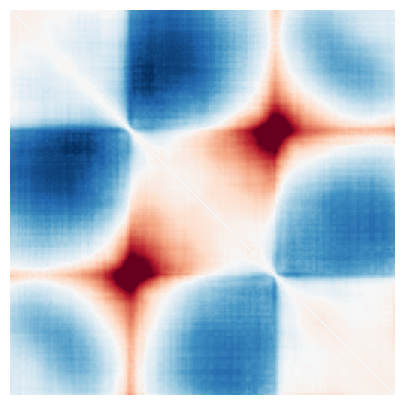

exp_id: 11, seq_id: 11, target_id: 1, background_id: 0


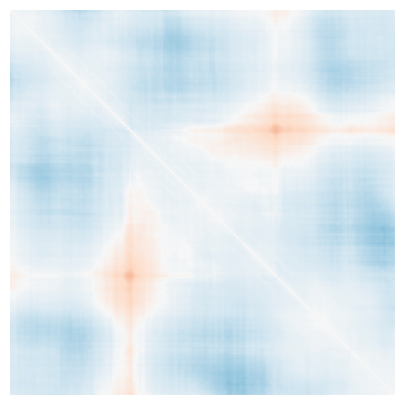

exp_id: 11, seq_id: 11, target_id: 4, background_id: 0


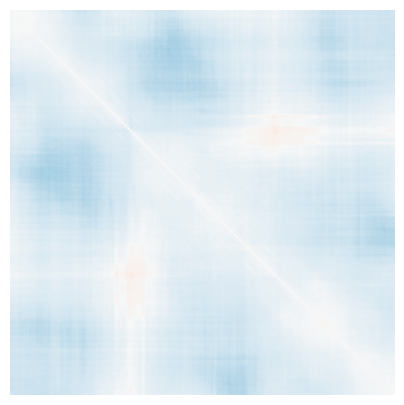

exp_id: 2000, seq_id: 2000, target_id: 1, background_id: 0


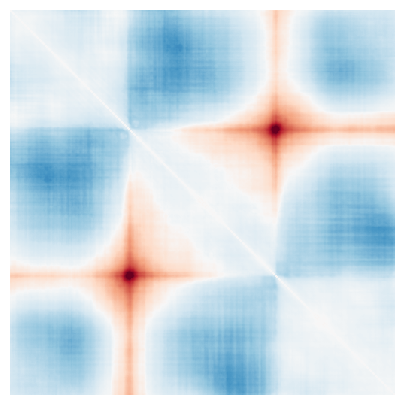

exp_id: 2000, seq_id: 2000, target_id: 4, background_id: 0


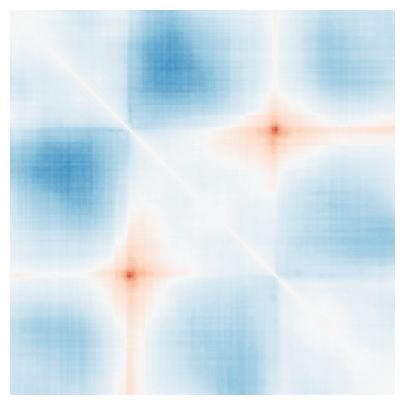

exp_id: 510, seq_id: 510, target_id: 1, background_id: 0


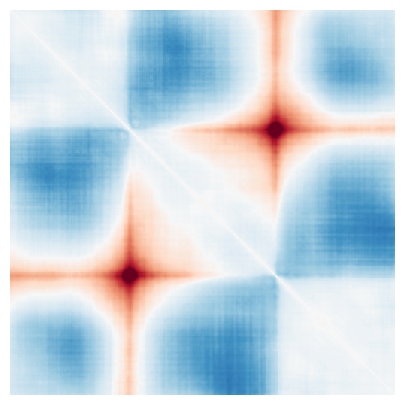

exp_id: 510, seq_id: 510, target_id: 4, background_id: 0


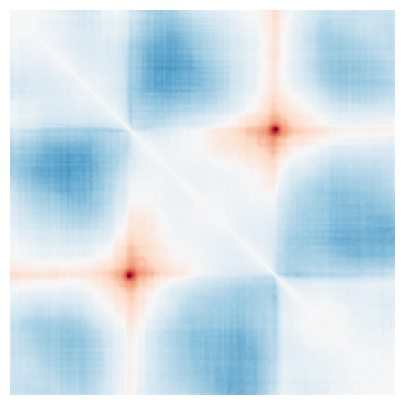

exp_id: 931, seq_id: 931, target_id: 1, background_id: 0


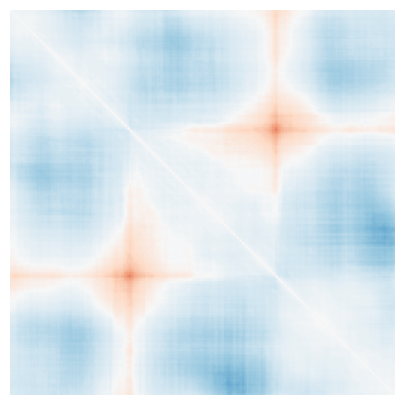

exp_id: 931, seq_id: 931, target_id: 4, background_id: 0


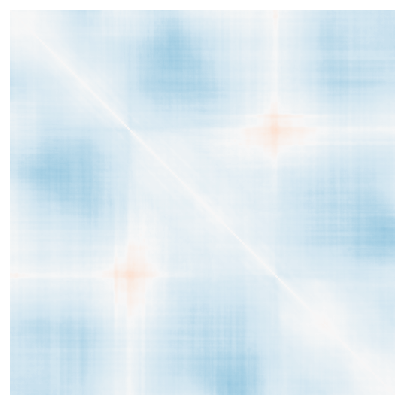

exp_id: 5680, seq_id: 5680, target_id: 1, background_id: 0


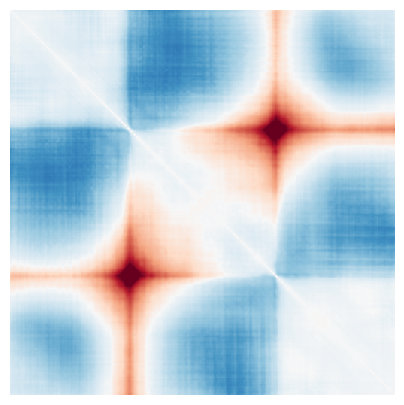

exp_id: 5680, seq_id: 5680, target_id: 4, background_id: 0


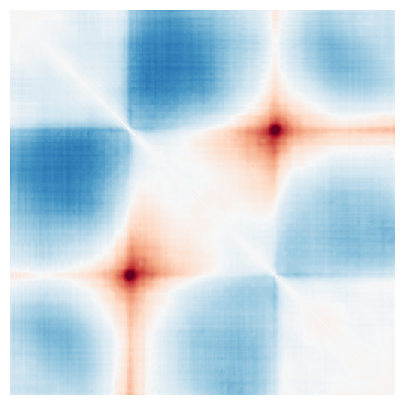

exp_id: 5750, seq_id: 5750, target_id: 1, background_id: 0


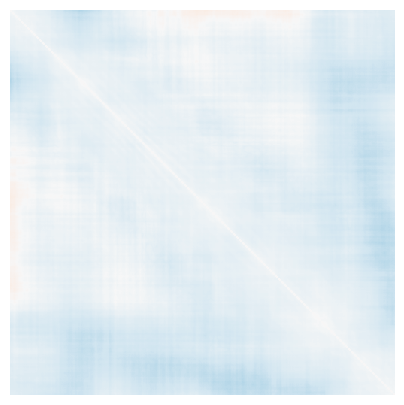

exp_id: 5750, seq_id: 5750, target_id: 4, background_id: 0


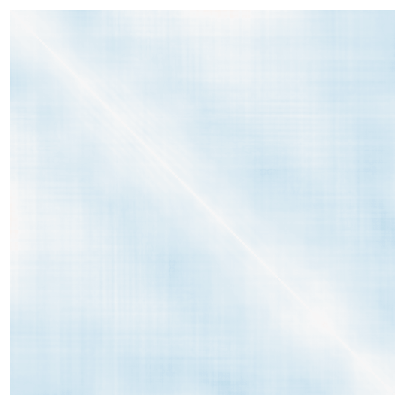

exp_id: 5886, seq_id: 5886, target_id: 1, background_id: 0


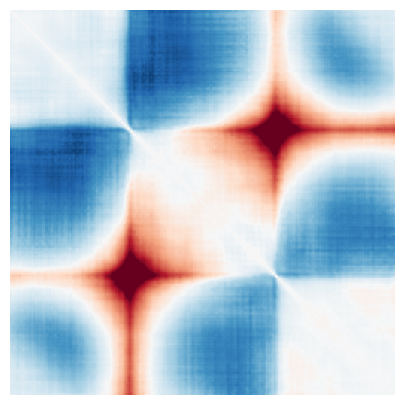

exp_id: 5886, seq_id: 5886, target_id: 4, background_id: 0


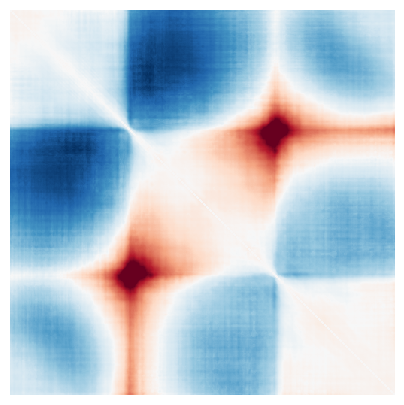

exp_id: 7470, seq_id: 7470, target_id: 1, background_id: 0


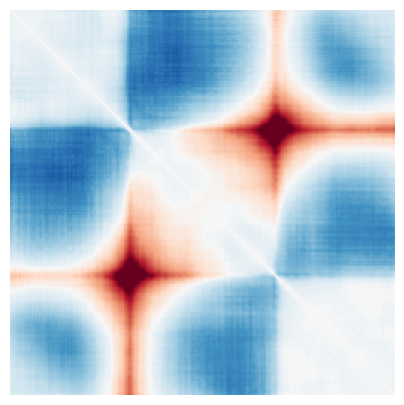

exp_id: 7470, seq_id: 7470, target_id: 4, background_id: 0


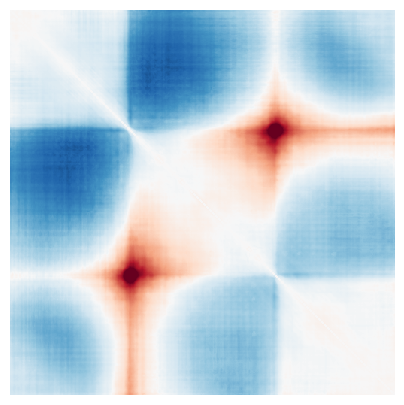

In [19]:
for job_index in job_list:

    job_h5_file = f"/scratch2/smaruj/corrected_dots_vs_boundaries/dots_all_motifs_m{model_index}/job{job_index}/OUT.h5"
    job_h5_open = h5py.File(job_h5_file, "r")
    
    # append to final
    for key in job_h5_open.keys():
            
        if (key[0] == "e" and key != "end" and key !="exp_id"):
                
            identifiers = key.split("_")
            exp_id = int(identifiers[0][1:])
            seq_id = int(identifiers[1][1:])
            target_id = int(identifiers[4][1:])
            background_id = int(identifiers[5][1:])

            if exp_id in sample_exp_id and seq_id in sample and background_id == request_bg_id and target_id in request_tg_ids:

                print(f"exp_id: {exp_id}, seq_id: {seq_id}, target_id: {target_id}, background_id: {background_id}")
            
                map_matrix = np.array(job_h5_open[key])

                plot_map(map_matrix)
    
    job_h5_open.close()